In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# MT-Bench Human Annotation Dataset - Win Rate

In [13]:
def compute_win_rate(df, model_name, winner_col):
    # Compute the win rate of a specific model
    model_rows = df[(df["model_a"] == model_name) | (df["model_b"] == model_name)]
    
    # Count wins
    wins = ((model_rows["model_a"] == model_name) & (model_rows[winner_col] == "model_a")) | ((model_rows["model_b"] == model_name) & (model_rows[winner_col] == "model_b"))
        
    return wins.sum() / len(model_rows)

In [14]:
def convert_to_binary_indicators(df, model_name):
    # Convert winner columns to binary indicators
    df = df.copy()
    
    # Filter for rows involving the model
    model_rows = (df["model_a"] == model_name) | (df["model_b"] == model_name)
    df = df[model_rows]
    
    # Calculate binary outcome for human judgments
    binary_human = (((df["model_a"] == model_name) & (df["winner_human"] == "model_a")) | ((df["model_b"] == model_name) & (df["winner_human"] == "model_b"))).astype(float)
    
    # Calculate binary outcome for GPT-4 judgments
    binary_gpt4 = (((df["model_a"] == model_name) & (df["winner_gpt4"] == "model_a")) | ((df["model_b"] == model_name) & (df["winner_gpt4"] == "model_b"))).astype(float)
    
    df["binary_human"] = binary_human
    df["binary_gpt4"] = binary_gpt4
    
    return df

In [15]:
def adjust_with_control_variates(df, sample_indices, tau):
    # Apply the control variates method to adjust the sampled estimate.

    sampled_df = df.iloc[sample_indices]
    
    covariance_m_t = np.cov(sampled_df["binary_human"], sampled_df["binary_gpt4"])[0, 1]
    var_t = sampled_df["binary_gpt4"].var()
    
    c_star = -covariance_m_t / var_t if var_t != 0 else 0
    
    adjusted_estimate = sampled_df["binary_human"].mean() + c_star * (sampled_df["binary_gpt4"].mean() - tau)
    
    return adjusted_estimate

In [ ]:
def importance_sampling(df, model_name, sample_size, confidence_col="gpt4_confidence"):
    """Apply importance sampling using GPT-4 confidence scores as weights"""
    # Get dataframe for this model
    model_df = convert_to_binary_indicators(df, model_name)
        
    # Calculate sampling probabilities based on confidence scores
    # Higher confidence = higher probability of being sampled
    weights = model_df[confidence_col] / model_df[confidence_col].sum()
    
    # Sample indices with replacement according to weights
    sample_indices = np.random.choice(
        len(model_df), 
        size=min(sample_size, len(model_df)), 
        replace=True, 
        p=weights
    )
    
    sampled_df = model_df.iloc[sample_indices]
    
    # Calculate the importance weights (inverse of sampling probability)
    # For each sampled index, get its original sampling probability
    sampling_probs = weights.iloc[sample_indices].values
    importance_weights = 1.0 / (sampling_probs * len(model_df))
    
    # Apply importance weights to the human binary indicators
    weighted_estimate = (sampled_df["binary_human"] * importance_weights).sum() / importance_weights.sum()
    
    return weighted_estimate

In [17]:
def run_sampling_analysis(df, model_name, sampling_rates, num_trials=1000):
    # Run sampling analysis with both uniform and control variates methods

    # Compute baseline metrics
    win_rate_human = compute_win_rate(df, model_name, "winner_human")
    win_rate_llm = compute_win_rate(df, model_name, "winner_gpt4")
    relative_error_llm = abs(win_rate_llm - win_rate_human) / win_rate_human * 100

    # Convert to binary indicators
    df = convert_to_binary_indicators(df, model_name)
    
    # Sampling analysis
    np.random.seed(42)
    avg_relative_errors = []
    avg_relative_errors_control_variates = []
    avg_relative_errors_importance = []
    
    for rate in sampling_rates:
        sample_size = int(rate * len(df))
        relative_errors = []
        relative_errors_control_variates = []
        relative_errors_importance = []
        
        for i in range(num_trials):
            sample_indices = np.random.choice(len(df), size=sample_size, replace=False)
            sampled_df = df.iloc[sample_indices]
            
            # Uniform sampling
            uniform_win_rate = sampled_df["binary_human"].mean()
            relative_error = abs(uniform_win_rate - win_rate_human) / win_rate_human * 100
            relative_errors.append(relative_error)
            
            # Control variates
            adjusted_win_rate = adjust_with_control_variates(df, sample_indices, win_rate_llm)
            relative_error_cv = abs(adjusted_win_rate - win_rate_human) / win_rate_human * 100
            relative_errors_control_variates.append(relative_error_cv)

            # Importance sampling
            importance_win_rate = importance_sampling(df, model_name, sample_size)
            relative_error_imp = abs(importance_win_rate - win_rate_human) / win_rate_human * 100
            relative_errors_importance.append(relative_error_imp)
        
        avg_relative_errors.append(np.mean(relative_errors))
        avg_relative_errors_control_variates.append(np.mean(relative_errors_control_variates))
        avg_relative_errors_importance.append(np.mean(relative_errors_importance))
    
    return {
        'win_rate_human': win_rate_human,
        'win_rate_llm': win_rate_llm,
        'relative_error_llm': relative_error_llm,
        'avg_relative_errors': avg_relative_errors,
        'avg_relative_errors_cv': avg_relative_errors_control_variates,
        'avg_relative_errors_importance': avg_relative_errors_importance
    }

In [18]:
def plot_results(results, sampling_rates, dataset_size, model_name):
    # Plot the analysis results
    
    plt.figure(figsize=(10, 6))
    plt.plot(sampling_rates * dataset_size, results['avg_relative_errors'], 
             '-', color='blue', label='Uniform Sampling')
    plt.plot(sampling_rates * dataset_size, results['avg_relative_errors_cv'], 
             '-', color='green', label='With Control Variates')
    plt.plot(sampling_rates * dataset_size, results['avg_relative_errors_importance'], 
             '-', color='purple', label='Importance Sampling')
    plt.axhline(y=results['relative_error_llm'], color='red', 
                linestyle='--', label='LLM Baseline')

    plt.xlabel("# Human Labels")
    plt.ylabel("Relative Error (%)")
    plt.legend()
    plt.grid(True)
    plt.title(f"Relative Error of Win Rate Estimation for {model_name}")
    plt.show()

In [19]:
def analyze_model(model_name, df, num_trials=1000):
    # Run complete analysis for a specific model
    sampling_rates = np.linspace(0.001, 0.2, 20)

    # Run analysis
    results = run_sampling_analysis(df, model_name, sampling_rates, num_trials)
    
    # Print results
    print(f"\nResults for {model_name}:")
    print(f"Win Rate (Human Judges): {results['win_rate_human']:.3f}")
    print(f"Win Rate (LLM Judges): {results['win_rate_llm']:.3f}")
    print(f"Relative Error (LLM vs. Human): {results['relative_error_llm']:.2f}%")
    
    # Plot results
    plot_results(results, sampling_rates, len(df), model_name)
    
    return results

In [20]:
judge_df = pd.read_csv("mt_bench_with_gpt_confidence.csv")

/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_22057/3675406140.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance_m_t = np.cov(sampled_df["binary_human"], sampled_df["binary_gpt4"])[0, 1]
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_22057/1132182184.py:34: RuntimeWarning: invalid value encountered in scalar divide
  weighted_estimate = (sampled_df["binary_h


Results for gpt-3.5-turbo:
Win Rate (Human Judges): 0.504
Win Rate (LLM Judges): 0.641
Relative Error (LLM vs. Human): 27.23%


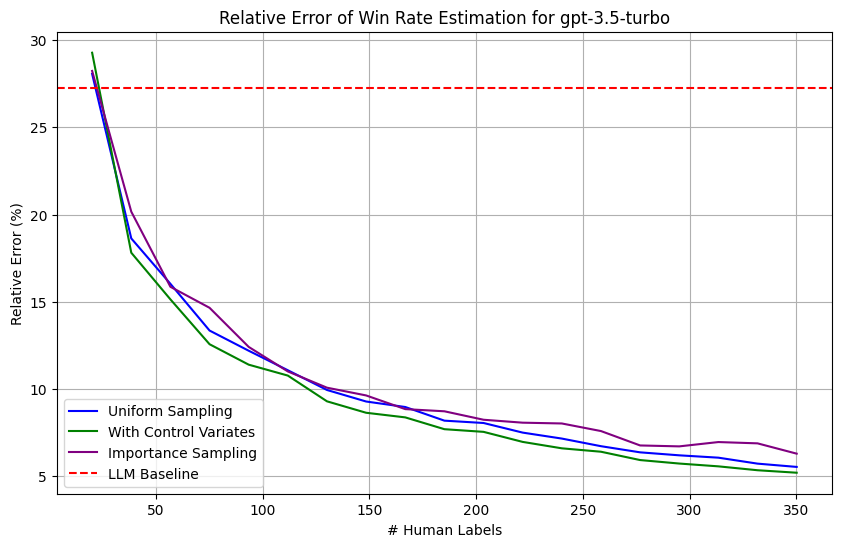

/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_22057/3675406140.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance_m_t = np.cov(sampled_df["binary_human"], sampled_df["binary_gpt4"])[0, 1]
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_22057/1132182184.py:34: RuntimeWarning: invalid value encountered in scalar divide
  weighted_estimate = (sampled_df["binary_h


Results for claude-v1:
Win Rate (Human Judges): 0.495
Win Rate (LLM Judges): 0.697
Relative Error (LLM vs. Human): 40.66%


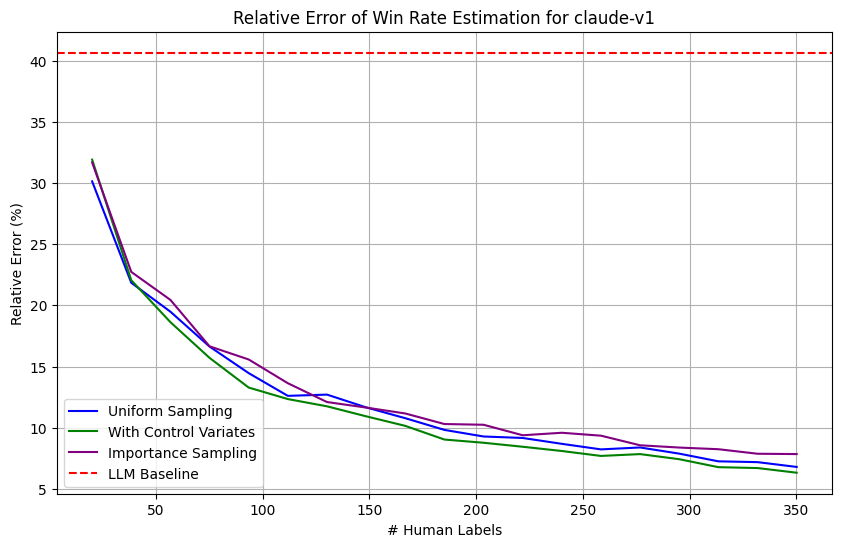

/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_22057/3675406140.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance_m_t = np.cov(sampled_df["binary_human"], sampled_df["binary_gpt4"])[0, 1]
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_22057/1132182184.py:34: RuntimeWarning: invalid value encountered in scalar divide
  weighted_estimate = (sampled_df["binary_h


Results for vicuna-13b-v1.2:
Win Rate (Human Judges): 0.326
Win Rate (LLM Judges): 0.463
Relative Error (LLM vs. Human): 41.80%


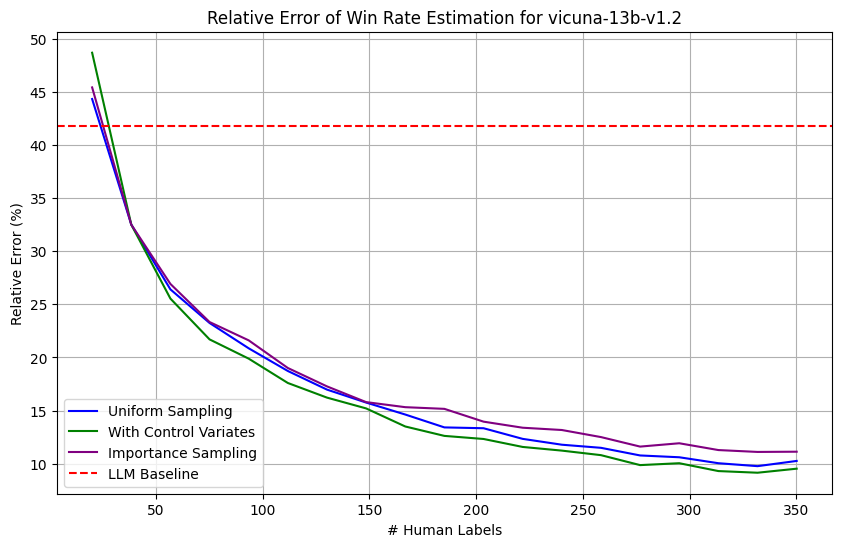

/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_22057/3675406140.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance_m_t = np.cov(sampled_df["binary_human"], sampled_df["binary_gpt4"])[0, 1]
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_22057/1132182184.py:34: RuntimeWarning: invalid value encountered in scalar divide
  weighted_estimate = (sampled_df["binary_h


Results for llama-13b:
Win Rate (Human Judges): 0.076
Win Rate (LLM Judges): 0.047
Relative Error (LLM vs. Human): 38.10%


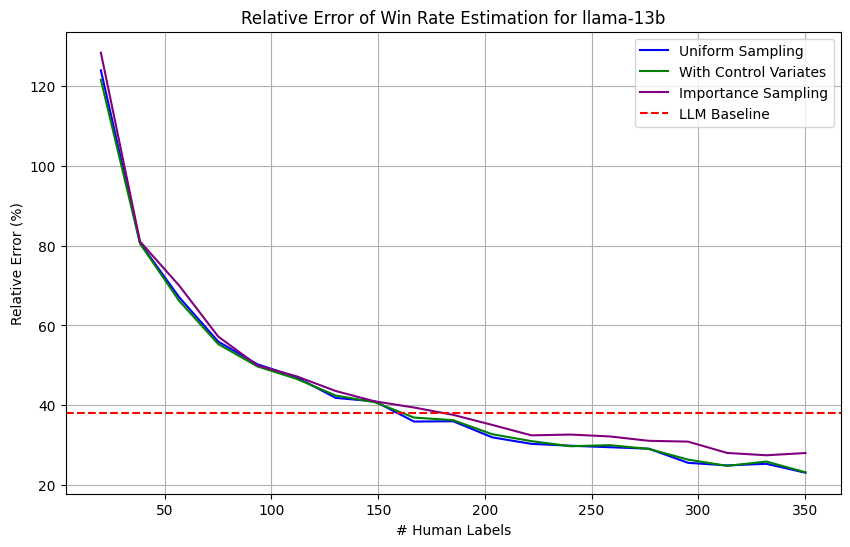

/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_22057/3675406140.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance_m_t = np.cov(sampled_df["binary_human"], sampled_df["binary_gpt4"])[0, 1]
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_22057/1132182184.py:34: RuntimeWarning: invalid value encountered in scalar divide
  weighted_estimate = (sampled_df["binary_h


Results for gpt-4:
Win Rate (Human Judges): 0.623
Win Rate (LLM Judges): 0.835
Relative Error (LLM vs. Human): 34.01%


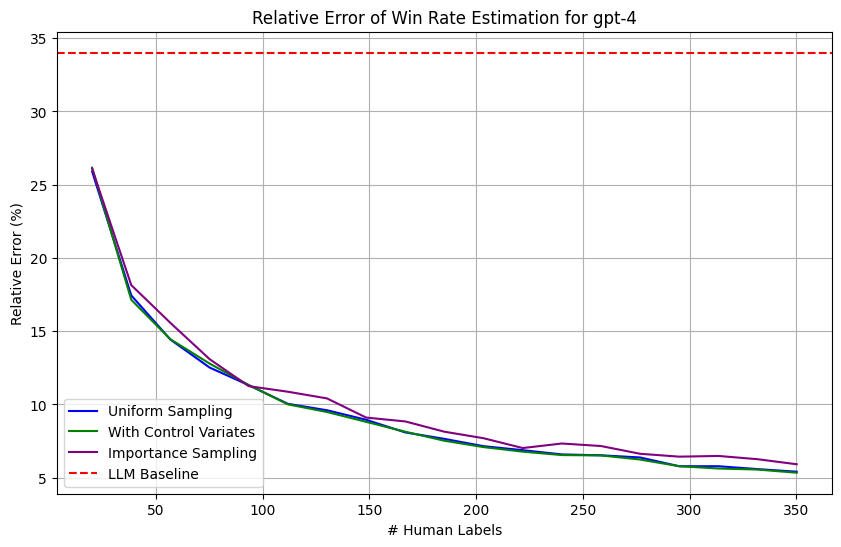

/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_22057/3675406140.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance_m_t = np.cov(sampled_df["binary_human"], sampled_df["binary_gpt4"])[0, 1]
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/nangia/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_22057/1132182184.py:34: RuntimeWarning: invalid value encountered in scalar divide
  weighted_estimate = (sampled_df["binary_h


Results for alpaca-13b:
Win Rate (Human Judges): 0.192
Win Rate (LLM Judges): 0.177
Relative Error (LLM vs. Human): 7.53%


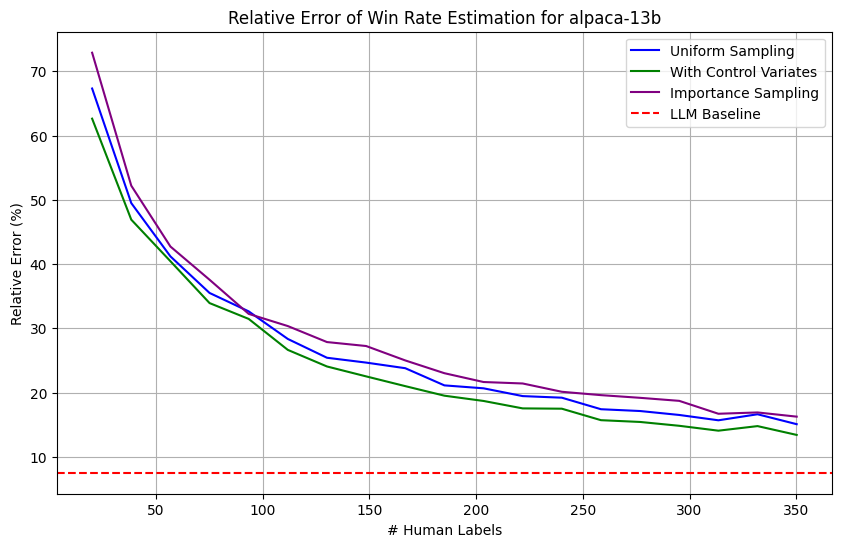

{'win_rate_human': 0.19175257731958764,
 'win_rate_llm': 0.177319587628866,
 'relative_error_llm': 7.526881720430109,
 'avg_relative_errors': [nan,
  67.31182795698923,
  49.482795698924726,
  41.19032258064516,
  35.500537634408595,
  32.63311827956989,
  28.340143369175628,
  25.416099163679807,
  24.6635457644899,
  23.79053295932679,
  21.11707779886148,
  20.661098310291855,
  19.449621011810326,
  19.202443792766367,
  17.407193699833407,
  17.127504244482175,
  16.514748440196463,
  15.684571142785694,
  16.623974949781402,
  15.080645161290322],
 'avg_relative_errors_cv': [nan,
  62.62141577060931,
  46.904103942652334,
  40.43931317786156,
  33.924593522385265,
  31.459400321896503,
  26.63857094191498,
  24.05917759573307,
  22.518165255240838,
  21.000064215236318,
  19.51367591933566,
  18.693818408812366,
  17.537027813546914,
  17.489595220814795,
  15.702098410630382,
  15.42609946689129,
  14.82961715629649,
  14.068749668669279,
  14.781662976561297,
  13.4093704439579

In [22]:
# GPT-3.5 Turbo
analyze_model(
    model_name="gpt-3.5-turbo",
    df=judge_df
)

# Analyze Claude-v1
analyze_model(
    model_name="claude-v1",
    df=judge_df
)

# Analyze Vicuna-13b-v1.2
analyze_model(
    model_name="vicuna-13b-v1.2",
    df=judge_df
)

# Analyze Llama-13b
analyze_model(
    model_name="llama-13b",
    df=judge_df
)

# Analyze GPT-4
analyze_model(
    model_name="gpt-4",
    df=judge_df
)

# Analyze alpaca-13b
analyze_model(
    model_name="alpaca-13b",
    df=judge_df
)